In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-prices-historical/coffee-prices-historical-chart-data.csv


In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import pytorch_lightning as pl
from pytorch_lightning import seed_everything, LightningModule, Trainer

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plotsize = (13, 5)

# Exploratory Data Analysis

Let's start by looking at the dataset. In this section we want to familiarise ourselves with the dataset, see if there are any missing values and replace them, and see if the time series is consistent

In [7]:
# Read the dataset. Since the dataset has a column named date, 
# we use this column to parse dates and also set it as the index column
df_coffee_prices = pd.read_csv('/kaggle/input/coffee-prices-historical/coffee-prices-historical-chart-data.csv',
parse_dates=['date'], index_col="date")

# Display the dataset
display(df_coffee_prices.head())

# Some information about the dataset
print(f"\n Total number of rows in the dataset: {df_coffee_prices.shape[0]}.")
print(f"\n Total number of columns in the dataset: {df_coffee_prices.shape[1]}.")

,value
date,
1973-08-20,0.6735
1973-08-21,0.6710
1973-08-22,0.6580
1973-08-23,0.6675
1973-08-24,0.6660



 Total number of rows in the dataset: 12168.

 Total number of columns in the dataset: 1.


First of all, one has to look if there are any missing dates in the dataset. 

In [8]:
# Compute unique dates in dataset
print(f'\n Unique dates in the dataset: {len(df_coffee_prices.index.unique())}.')

# Compute range of dates in the dataset
our_range = df_coffee_prices.index.max() - df_coffee_prices.index.min()

# Number of days in date range
print(f'\n Total days in the date range of the dataset: {our_range.days} days.')


 Unique dates in the dataset: 12168.

 Total days in the date range of the dataset: 17707 days.


We can conclude that there are 17707 - 12168 = **5539** missing dates. 

So, we create a new index containing all dates from 1973-08-20 to 2022-02-11 and replace the old index with the one. At the same time, we fill the *new* the missing data with NaN values. 

In [9]:
# Define new index for the dataset
new_index = pd.date_range(df_coffee_prices.index.min(), df_coffee_prices.index.max())

# Replace the old index with the new and fill missing values with NaN
df_coffee_prices = df_coffee_prices.reindex(new_index, fill_value=np.nan)

print(df_coffee_prices.index)

DatetimeIndex(['1973-08-20', '1973-08-21', '1973-08-22', '1973-08-23',
               '1973-08-24', '1973-08-25', '1973-08-26', '1973-08-27',
               '1973-08-28', '1973-08-29',
               ...
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11'],
              dtype='datetime64[ns]', length=17708, freq='D')


We can see that the Datetimeindex has a daily frequency now. In fact, *freq='D'*.

In [10]:
print(f"\n Number of NaN values in dataset: {df_coffee_prices.isna().sum().sum()}.")


 Number of NaN values in dataset: 5561.


Note that the number of NaN values is bigger than the number of missing values. This is totally possible as there already were dates with missing values.

We print the time series to visually check if there are big chunks of missing data.

<AxesSubplot:title={'center':'Value of one pound of coffee from 1973 to 2022'}, xlabel='Date', ylabel='Value'>

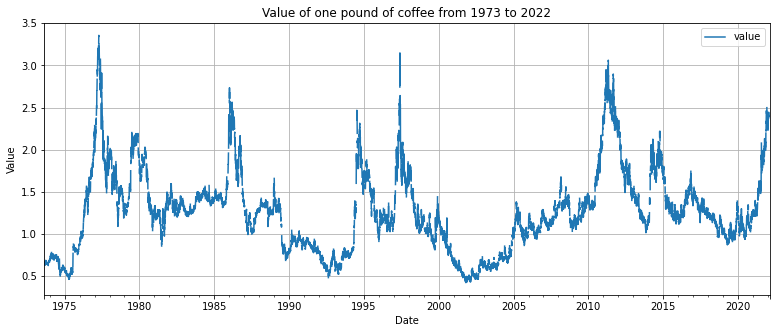

In [11]:
df_coffee_prices.plot(figsize=plotsize, 
              grid=True, 
              title="Value of one pound of coffee from 1973 to 2022", 
              xlabel="Date",
              ylabel="Value")

Hopefully, there are not big chunks of missing data. Most of the data imputation techniques work if the missing values are intermittent. However, we will fill in the blanks using linear interpolation. 

In [12]:
# Make a copy of df_coffee_prices
df_coffee_prices_old = df_coffee_prices.copy()

# Fill df_coffee_prices missing values with interpolation
df_coffee_prices = df_coffee_prices.interpolate(method='linear', axis=0)

# Print the number of NaN values in df_coffee_prices after interpolation
print(f"\n Number of NaN values in dataset: {df_coffee_prices.isna().sum().sum()}.")

# Print the description of df_coffee_prices before and after interpolation
print(f"\n df_coffe_prices description:")
display(df_coffee_prices.describe())
print(f"\n df_coffe_prices_old description:")
display(df_coffee_prices_old.describe())


 Number of NaN values in dataset: 0.

 df_coffe_prices description:


,value
count,17708.000000
mean,1.267087
std,0.480324
min,0.425000
25%,0.945000
50%,1.236500
75%,1.470500
max,3.356300



 df_coffe_prices_old description:


,value
count,12147.000000
mean,1.267276
std,0.478930
min,0.425000
25%,0.948500
50%,1.237000
75%,1.470000
max,3.356300


We can see from the two description's tables that the interpolated dataframe didn't change too much from a statistical point of view. 

We print another time the time series.

<AxesSubplot:title={'center':'Value of one pound of coffee from 1973 to 2022'}, xlabel='Date', ylabel='Value'>

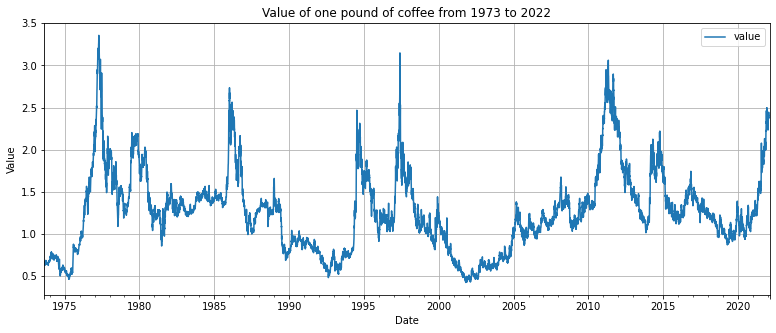

In [13]:
df_coffee_prices.plot(figsize=plotsize, 
              grid=True, 
              title="Value of one pound of coffee from 1973 to 2022", 
              xlabel="Date",
              ylabel="Value")

Now, the time series look more continuous.

The next task is to normalise the data. We decided to use a MinMaxscaler. 

<AxesSubplot:title={'center':'Normalized Value of one pound of coffee from 1973 to 2022'}, xlabel='Date', ylabel='Value'>

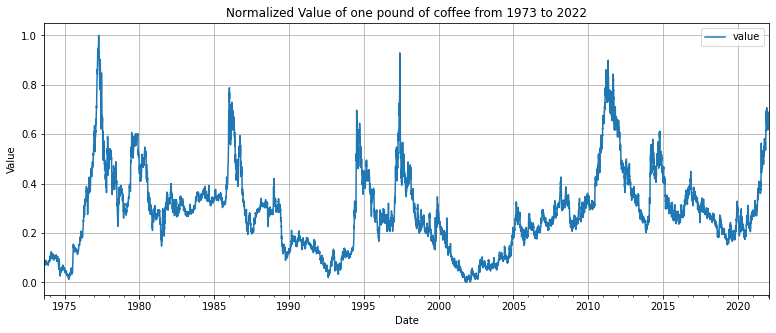

In [14]:
min_value = df_coffee_prices.min()
max_value = df_coffee_prices.max()

df_coffee_prices_normalized = (df_coffee_prices-min_value)/(max_value-min_value)
df_coffee_prices_normalized.plot(figsize=plotsize, 
              grid=True, 
              title="Normalized Value of one pound of coffee from 1973 to 2022", 
              xlabel="Date",
              ylabel="Value")

# Splitting the dataset into train, validation and test sets

In this section we want to divide the time series into train set, validation set and test set. To this aim, we first need to know a little about the time series. 

In [17]:
# Print the start date
print(f"\n Date starting from: {df_coffee_prices_normalized.index.min()}.")

# Print the end date
print(f"\n Date end: {df_coffee_prices_normalized.index.max()}.")

# Printe the total number of dates
print(f"\n Total dates: {len(df_coffee_prices_normalized.index)}.")


 Date starting from: 1973-08-20 00:00:00.

 Date end: 2022-02-11 00:00:00.

 Total dates: 17708.


We want **80%** of the dates for the train set, **15%** for the validation set and the rest **5%** for the test set. This means that:
* the dates from **1973-08-20** to **2012-06-01** (14'166 days) are in the train set;
* the dates from **2012-06-02** to **2019-09-10** (2'657 days) are in the validation set;
* the dates from **2019-10-11** to **2022-02-11** (885 days) are in the test set.

In [18]:
# Define the train set
df_train = df_coffee_prices_normalized.loc[:datetime.datetime(year=2012,month=6,day=1)]

# Print the total number of rows in the train set and the start/end date
print("\n Total number of rows in train dataset:", df_train.shape[0])
print("\n Train dataset start date :",df_train.index.min())
print("\n Train dataset end date:",df_train.index.max())


 Total number of rows in train dataset: 14166

 Train dataset start date : 1973-08-20 00:00:00

 Train dataset end date: 2012-06-01 00:00:00


In [19]:
# Define the validation set
df_val = df_coffee_prices_normalized.loc[datetime.datetime(year=2012,month=6,day=2): 
                                         datetime.datetime(year=2019,month=9,day=10)]

# Print the total number of rows in the validation set and the start/end date
print("\n Total number of rows in validation dataset:", df_val.shape[0])
print("\n Validation dataset start date :",df_val.index.min())
print("\n Validation dataset end date:",df_val.index.max())


 Total number of rows in validation dataset: 2657

 Validation dataset start date : 2012-06-02 00:00:00

 Validation dataset end date: 2019-09-10 00:00:00


In [20]:
# Define the test set
df_test = df_coffee_prices_normalized.loc[datetime.datetime(year=2019,month=9,day=11):]

# Print the total number of rows on the train set and the start/end date
print("\n Total number of rows in the test dataset:", df_test.shape[0])
print("\n Test dataset start date :",df_test.index.min())
print("\n Test dataset end date:",df_test.index.max())


 Total number of rows in the test dataset: 885

 Test dataset start date : 2019-09-11 00:00:00

 Test dataset end date: 2022-02-11 00:00:00


# Creating the Dataset

We have finally arrived at the point where we have to create the dataset to be given afterwards to our pytorch model. 

So, we will be loading the training, validation, and testing DataFrames that we split earlier and creating features from these DataFrames to be used in the model. The output of this custom dataset class will be used to create a data loader in a later part of this section.

In time series forecasting historical data plays an important role in making future predictions. The most commonly used process to make accessible to the model the historical data is called "windowing". The fixed windows give the model the span to work with rolling targets (as explained in the previous section).

We decide to use 365 days (one year) as window size. But this is not mandatory. One should try to find the better window size for the model. 

In [22]:
class CoffeePricesDataset(torch.utils.data.Dataset):
    
    def __init__(self, train=False, validation=False, test=False, window_size=365):

        # Load the data
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
    
        # Creating Features
        if train: #process train dataset
            features = self.df_train
            target = self.df_train.value
        elif validation: #process validation dataset
            features = self.df_val
            target = self.df_val.value
        else: #process test dataset
            features = self.df_test
            target = self.df_test.value
    
        # Create windows/sequencing
        self.x, self.y = [], []
        for i in range(len(features) - window_size):
            window = features.iloc[i:(i + window_size)].values
            self.x.append(window)
            self.y.append(target.iloc[i + window_size])
    
        # Calculate length of dataset
        self.num_sample = len(self.x)
    
    # Implement the getitem method
    def __getitem__(self, index):
        x = self.x[index].astype(np.float32)
        y = self.y[index].astype(np.float32)
        return x, y
    
    # Implement the length method
    def __len__(self):
        #returns the total number of records for data set
        return self.num_sample

We give an example as our dataset class works:

In [23]:
# Creates and instance of the CoffeePricesDataset class
coffee_prices = CoffeePricesDataset(train=True)

np.set_printoptions(threshold=3)
print(f"\n Total number of windows: {coffee_prices.__len__()} (= {len(df_train)} - 365).")
print(f"\n Size of the window: {coffee_prices.__getitem__(0)[0].shape}.")
print(f"\n Printing features: {coffee_prices.__getitem__(0)[0]}.")
print(f"\n Printing target: {coffee_prices.__getitem__(0)[1]}.")


 Total number of windows: 13801 (= 14166 - 365).

 Size of the window: (365, 1).

 Printing features: [[0.08477467]
 [0.08392181]
 [0.07948691]
 ...
 [0.0561753 ]
 [0.05486758]
 [0.05355985]].

 Printing target: 0.06038276478648186.


Note that the size of a window is (window size, total number of features). In our case, we have a window size of 365 days as discussed and just one feature (the cost of one pound of coffee). 

# Defining the model using PyTorch Lightning

We decide to use a LSTM model for this problem. 

In [24]:
class CoffeePricesModel(pl.LightningModule):
    
    def __init__(self, input_size=1, output_size=1, hidden_dim=10, n_layers=2, window_size=365):
        """
        Parameters:
        -----------
            input_size: int
                Number of features in the input. In our case just one, as is an univariate time series
            output_size: int
                Number of items to be outputted. In our case one, as it is a regression problem
            hidden_dim: int
                Number of hidden layers 
            n_layers: int
                Number of RNN to stack over each other
            window_size: int
                Size of a window. In our case 365 by default
        """
        super(CoffeePricesModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.LSTM_block = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim * window_size, output_size)

        self.learning_rate = 0.001

        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim,device=x.device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim,device=x.device)
        hidden = (h0, c0)
        out, hidden = self.LSTM_block(x, hidden)
        out = self.relu(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        features, targets = train_batch
        output = self.forward(features) 
        output = output.view(-1)
        loss = nn.MSELoss()(output, targets)
        self.log('train_loss', loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, val_batch, batch_idx):
        features, targets = val_batch
        output = self.forward(features) 
        output = output.view(-1)
        loss = nn.MSELoss()(output, targets)
        self.log('val_loss', loss, prog_bar=True)

# Training the model

We can finally train our model.

In [25]:
batch_size = 30

train_dataset = CoffeePricesDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, persistent_workers=True)

val_dataset = CoffeePricesDataset(validation=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, persistent_workers=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
model = CoffeePricesModel()
trainer = pl.Trainer(accelerator="gpu", devices=2, strategy="ddp_notebook", max_epochs= 10)

In [27]:
trainer.fit(model, train_dataloader, val_dataloader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:539: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1282] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1282] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [28]:
! ls lightning_logs/version_0

checkpoints  events.out.tfevents.1673091036.1ec84be986d8.1649.0  hparams.yaml


# Model Evaluation

We have to look at whether the model generalises well over the test set. So in this section, we will evaluate the test set with the newly trained model and print out the results. 

In [29]:
# Call an istance of the CoffeePricesDataser for test data
test_dataset = CoffeePricesDataset(test=True)

# Creates the test dataloader
test_dataloader = DataLoader(test_dataset)

In [30]:
# Put in model in evaluation mode
trained_CoffeePricesModel = model
trained_CoffeePricesModel.eval()

CoffeePricesModel(
  (LSTM_block): LSTM(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=3650, out_features=1, bias=True)
  (relu): ReLU()
)

In [31]:
# Initialize Dataset
predicted_result, actual_result = [], []

# Let's loop it over single iteration and store the data in predicted_result and actual_result
for i, (features,targets) in enumerate(test_dataloader):
    result = trained_CoffeePricesModel(features)
    predicted_result.extend(result.view(-1).tolist())
    actual_result.extend(targets.view(-1).tolist())

In [32]:
# The data is filled in a dataframe
df_predictions = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
df_predictions = df_predictions.set_index([df_test.iloc[365: ].index.rename("date")])

# Reverse the normalization process
df_predictions["actual"] = df_predictions["actual"].apply(lambda x: x*(max_value-min_value)+min_value)
df_predictions["predicted"] = df_predictions["predicted"].apply(lambda x: x*(max_value-min_value)+min_value)

# Display the dataset with the prediction
display(df_predictions)

,actual,predicted
date,,
2020-09-10,1.317000,1.335146
2020-09-11,1.324500,1.340678
2020-09-12,1.293167,1.345464
2020-09-13,1.261833,1.349089
2020-09-14,1.230500,1.350237
...,...,...
2022-02-07,2.379000,2.406967
2022-02-08,2.379000,2.404055
2022-02-09,2.379000,2.400820


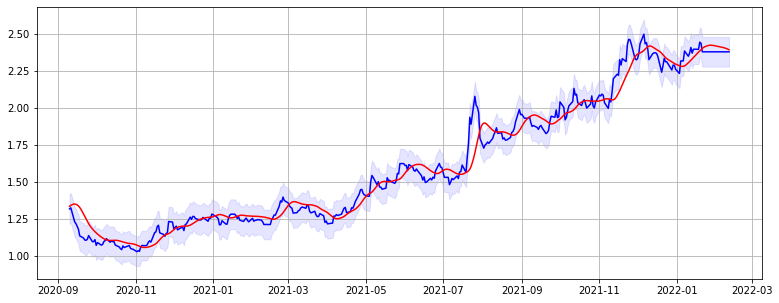


 The Mean Square Error on the test data is: 0.005228223586922367.

 The Mean Absolute Error on the test data is: 0.052091730066833014.


In [38]:
plt.figure(figsize= plotsize)
plt.grid()
plt.plot(df_predictions["actual"],'b')
plt.plot(df_predictions["predicted"],'r')
plt.fill_between(df_predictions.index,df_predictions["actual"]-0.1, df_predictions["actual"]+0.1, color='b', alpha=.1)
plt.show()

# Compute the mean squared and mean absolute errors metrics
MSE_on_real_data = (1/len(df_predictions.index))*sum((df_predictions.actual - df_predictions.predicted)**2)
MAE_on_real_data = (1/len(df_predictions.index))*sum(abs((df_predictions.actual - df_predictions.predicted)))

print(f"\n The Mean Square Error on the test data is: {MSE_on_real_data}.")
print(f"\n The Mean Absolute Error on the test data is: {MAE_on_real_data}.")